In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (18, 9)

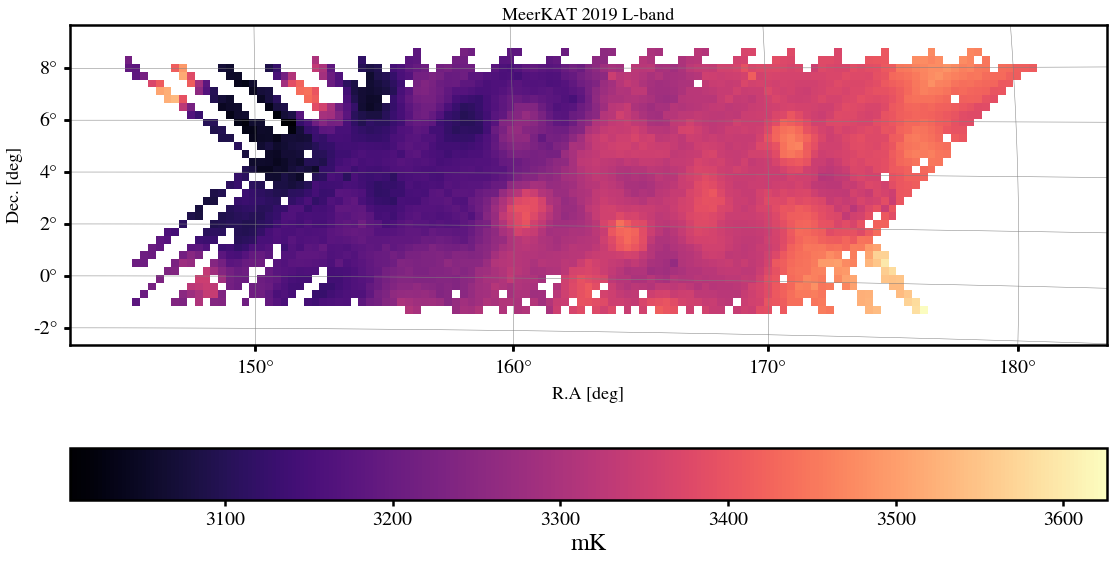

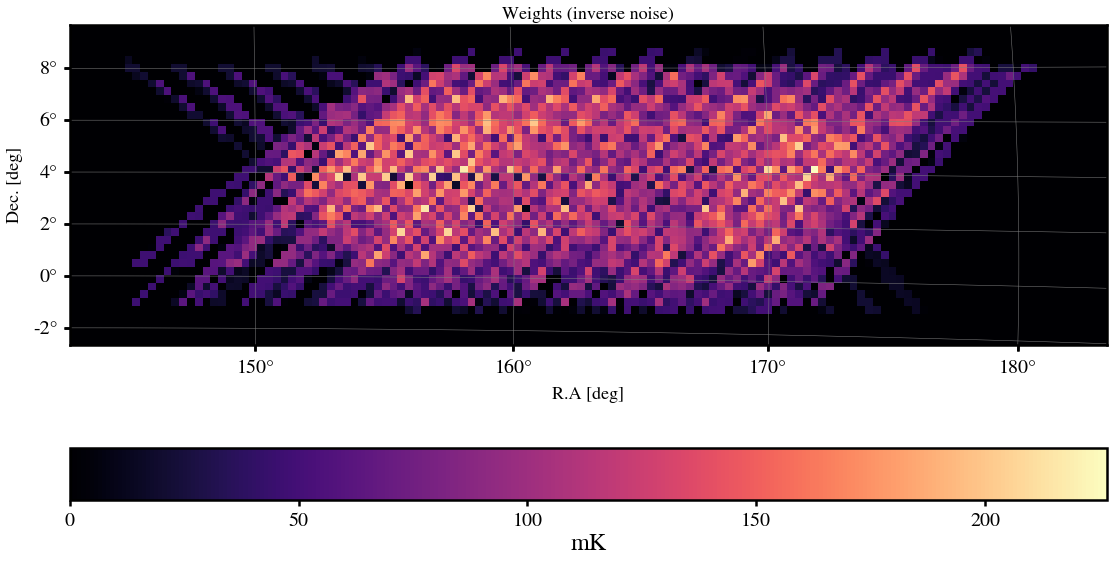

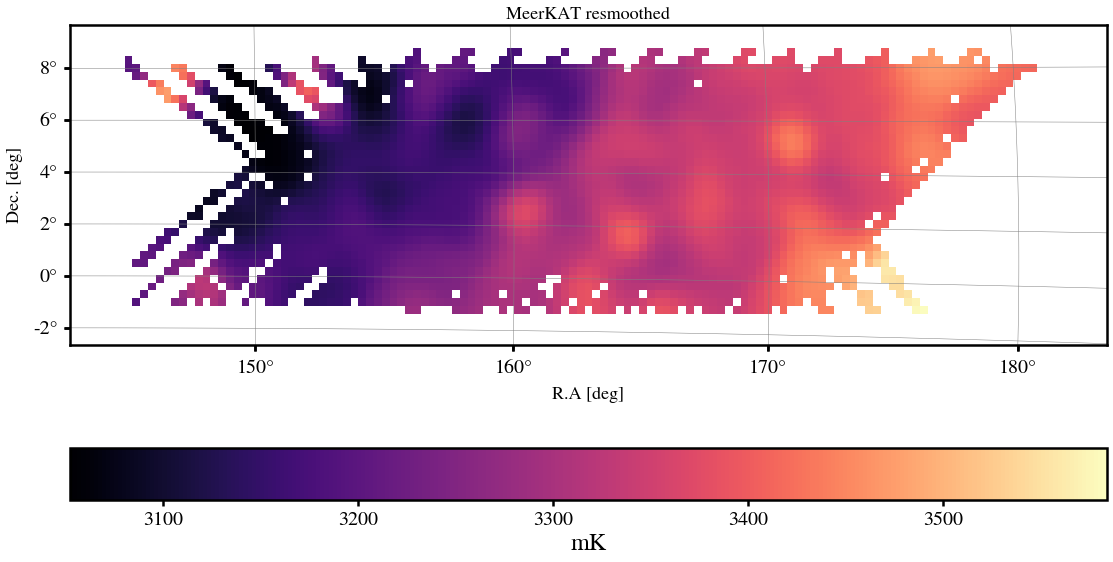

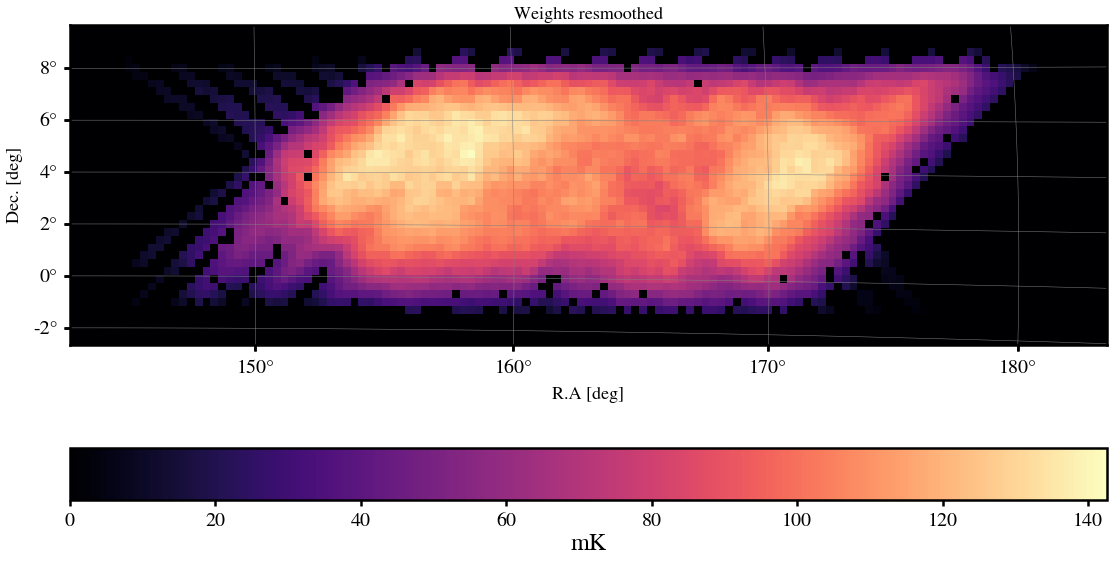

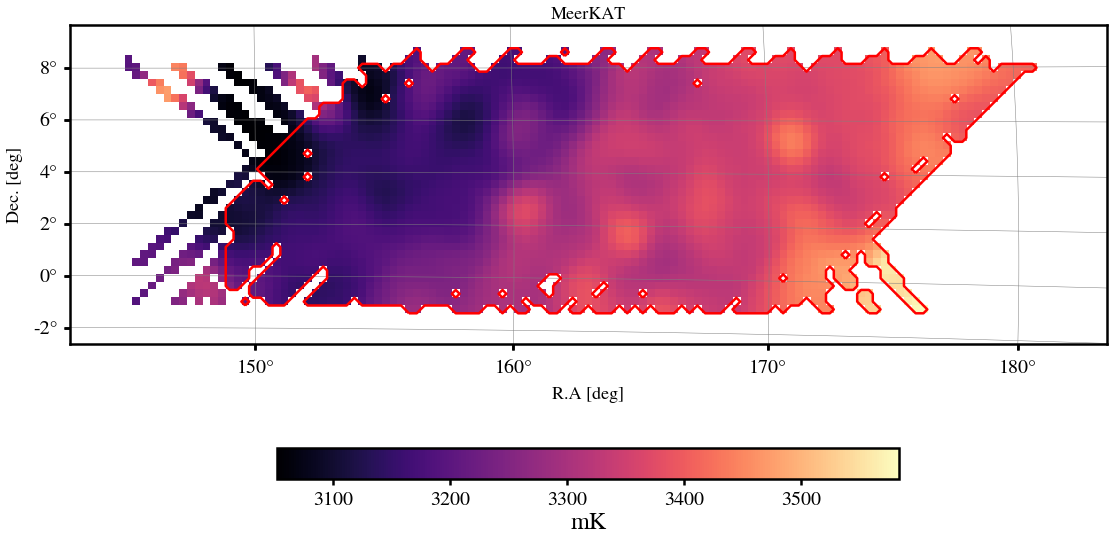

<Figure size 1296x648 with 0 Axes>

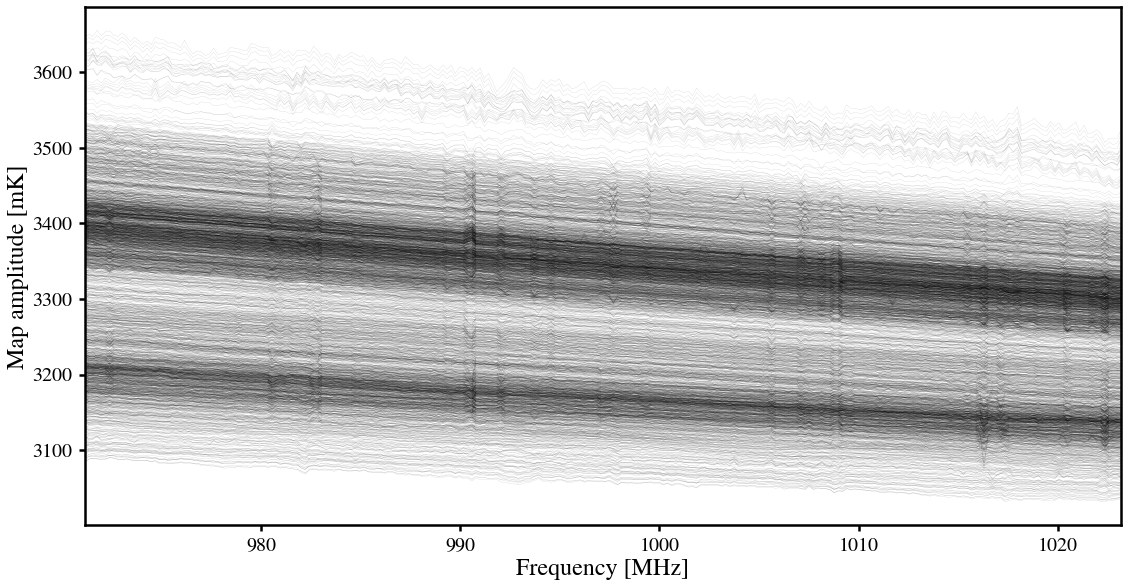

In [2]:
# Choose an L-band survey and read-in level6 MeerKAT data:
survey = '2019'
#survey = '2021'
doMock = False

if survey=='2019':
    filestem = '/idia/projects/hi_im/raw_vis/katcali_output/level6_output/p0.3d/p0.3d_sigma2.5_iter2/'
    map_file = filestem + 'Nscan366_Tsky_cube_p0.3d_sigma2.5_iter2.fits'
    numin,numax = 971,1023.2    
if survey=='2021':
    filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
    map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
    numin,numax = 971,1023.8 # default setting in Init.ReadIn()
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file,numin=numin,numax=numax)
if doMock==True: 
    mockindx = np.random.randint(100)
    MKmap_mock = np.load('/idia/projects/hi_im/meerpower/'+survey+'Lband/mocks/dT_HI_p0.3d_wBeam_%s.npy'%mockindx)
nx,ny,nz = np.shape(MKmap)

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### IM weights (averaging of counts along LoS so not to increase rank of the map for FG cleaning):
w_HI = np.repeat(np.mean(counts_HI,2)[:, :, np.newaxis], nz, axis=2)

### Plot maps:
plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT ' + survey + ' L-band',ZeroCentre=False)
plot.Map(w_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Weights (inverse noise)')
plt.show()

# Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
#from astropy.cosmology import Planck15 as cosmo_astropy
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift - defined as redshift of median frequency
zmin = (nu_21cm/np.max(nu)) - 1 # Minimum redshift of band
zmax = (nu_21cm/np.min(nu)) - 1 # Maximum redshift of band
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
r = 0.9 # cross-correlation coefficient
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))
gamma = 1.4 # resmoothing factor - set = None to have no resmoothing
#gamma = None

### Map resmoothing:
MKmap_unsmoothed = np.copy(MKmap)
if gamma is not None:
    w_HI_orig = np.copy(w_HI)
    MKmap,w_HI = telescope.weighted_reconvolve(MKmap,w_HI_orig,W_HI,ra,dec,nu,D_dish,gamma=gamma)
    if doMock==True: MKmap_mock,null = telescope.weighted_reconvolve(MKmap_mock,w_HI_orig,W_HI,ra,dec,nu,D_dish,gamma=gamma)
    plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
    plot.Map(w_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Weights resmoothed')
plt.show()

### Trim map edges:
doTrim = True
if doTrim==True:
    if survey=='2019':
        #raminMK,ramaxMK = 152,173
        #decminMK,decmaxMK = -1,8
        raminMK,ramaxMK = 149,190
        decminMK,decmaxMK = -5,20


    
    if survey=='2021':
        raminMK,ramaxMK = 334,357
        decminMK,decmaxMK = -35,-26.5
    ### Before trimming map, show contour of trimmed area:
    MKmap_untrim,W_HI_untrim = np.copy(MKmap),np.copy(W_HI)
    plot.Map(MKmap_untrim,W=W_HI_untrim,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT',cbarshrink=0.6)
    MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)

    if survey=='2019':
        cornercut_lim = 146 # set low to turn off
        cornercut = ra - dec < cornercut_lim
        MKmap[cornercut],w_HI[cornercut],W_HI[cornercut],counts_HI[cornercut] = 0,0,0,0

    contours = plt.contour(W_HI[:,:,0].T, levels=[0.5], colors='red')
    plt.show()

plot.LoSspectra(MKmap,W=W_HI,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()

### Spectral analysis for possible frequency channel flagging:

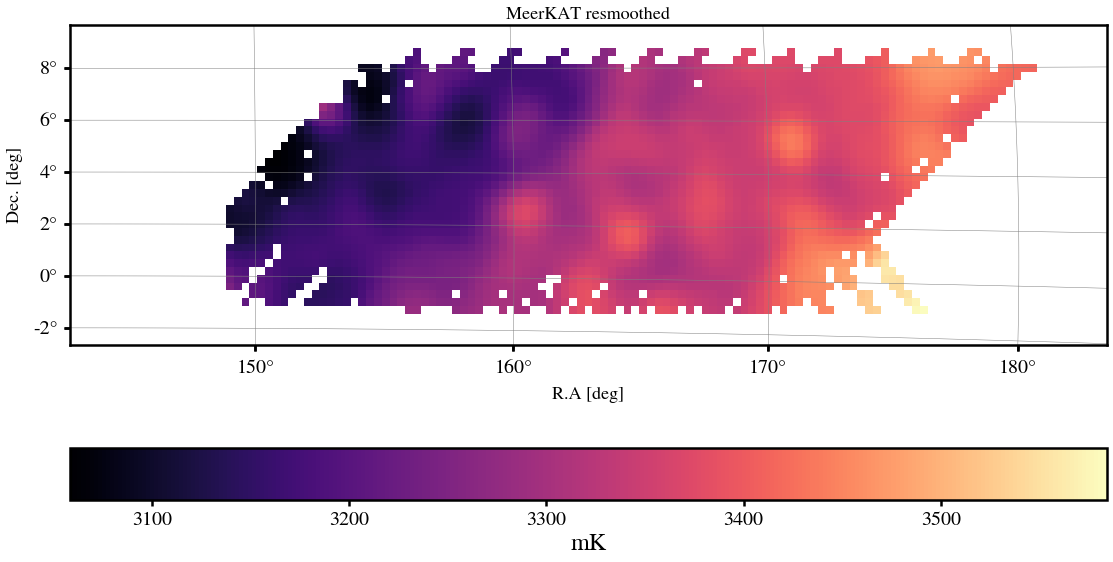

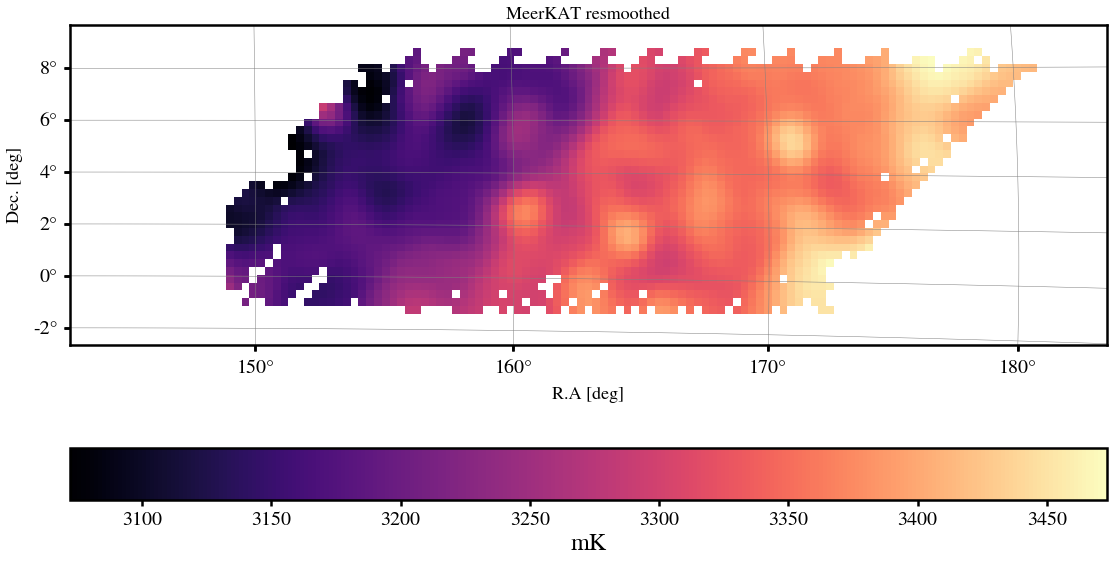

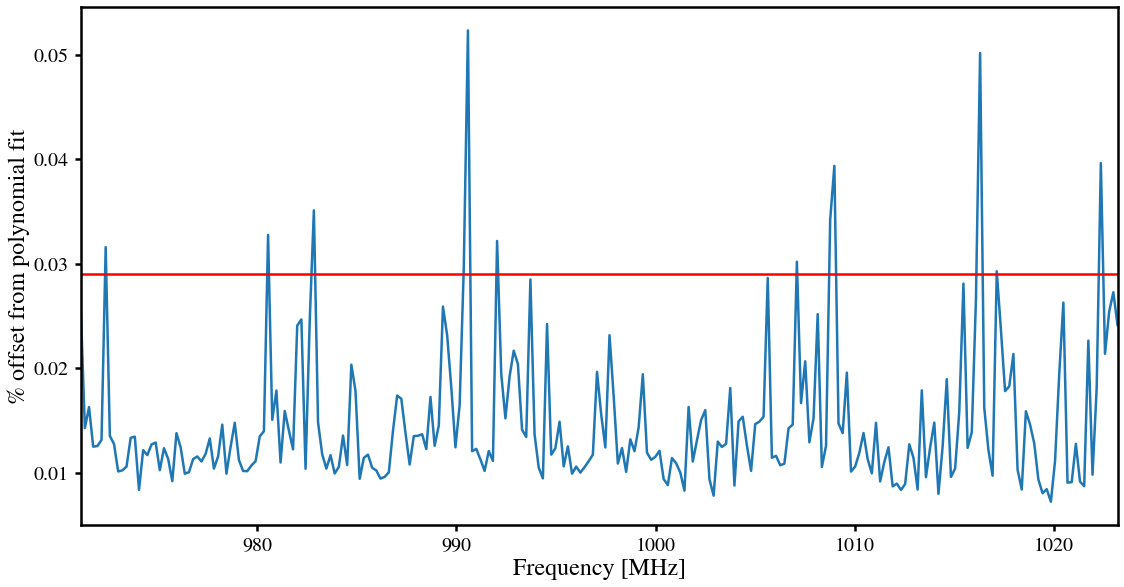

[  6  45  56  92  93 100 172 180 181 216 220 245]


<Figure size 1296x648 with 0 Axes>

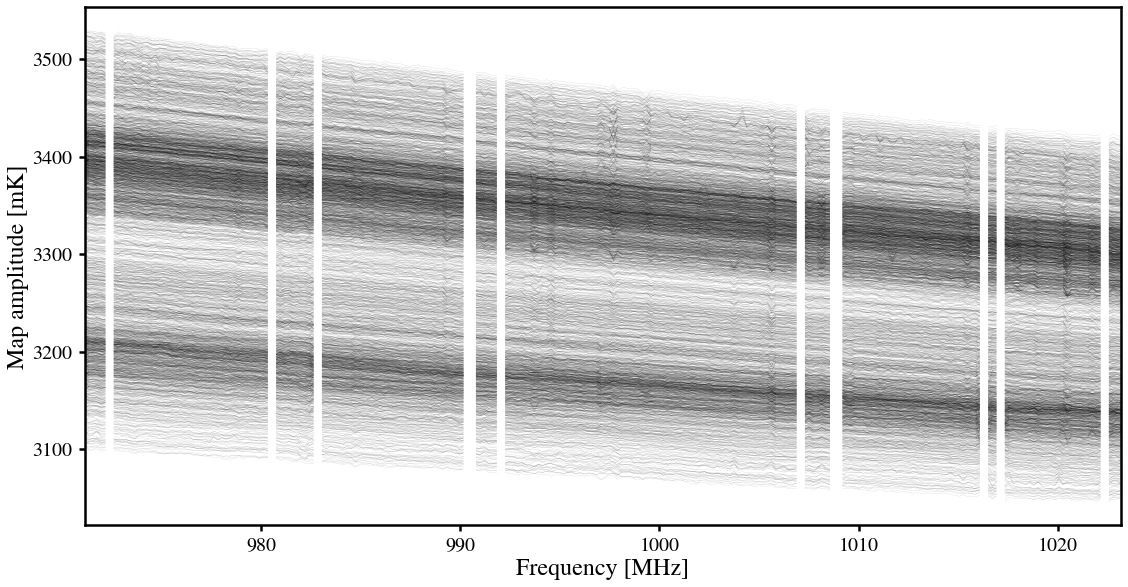

"\n### Analyse frequency variance to guide final flagging:\nvar = np.var(w_HI * MKmap,(0,1)) # variance in each frequnecy slice\npoly = model.FitPolynomial(nu,var,n=2)\noffsets = np.zeros(nz)\noffsets = np.abs(var - poly)\noffsetcut = 95e5 # Set to zero for no additional flagging\n#offsetcut = 0\nif offsetcut==0: flagindx = []\nelse: flagindx = np.where(offsets>offsetcut)[0]\nplt.plot(nu,var)\nplt.plot(nu,poly,color='black')\nplt.scatter(nu[flagindx],var[flagindx],color='red')\nplt.show()\nplt.axhline(offsetcut,color='red',ls='--')\nplt.plot(nu,offsets)\nplt.scatter(nu[flagindx],offsets[flagindx],color='red')\nplt.show()\nprint(flagindx)\n"

In [3]:
MKmap_flag,w_HI_flag,W_HI_flag = np.copy(MKmap),np.copy(w_HI),np.copy(W_HI)

plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
#'''
extreme_temp_LoS = np.zeros(np.shape(ra))
extreme_temp_LoS[MKmap[:,:,0]>3530] = 1
extreme_temp_LoS[MKmap[:,:,0]<3100] = 1
MKmap_flag[extreme_temp_LoS==1] = 0
w_HI_flag[extreme_temp_LoS==1] = 0
W_HI_flag[extreme_temp_LoS==1] = 0
plot.Map(MKmap_flag,W=W_HI_flag,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
#'''
plt.show()

import model
nra,ndec = np.shape(ra)
offsets = np.zeros((nra,ndec,len(nu)))
for i in range(nra):
    for j in range(ndec):
        if W_HI_flag[i,j,0]==0: continue
        poly = model.FitPolynomial(nu,MKmap_flag[i,j,:],n=2)
        offsets[i,j,:] = np.abs((MKmap_flag[i,j,:] - poly)/MKmap_flag[i,j,:])
offsets = 100*np.mean(offsets,axis=(0,1))

if survey=='2019': offsetcut = 0.029 # Set to zero for no additional flagging
#if survey=='2019': offsetcut = None # Set to None for no additional flagging
if survey=='2021': offsetcut = None
plt.plot(nu,offsets)
if offsetcut is not None: plt.axhline(offsetcut,color='red')
plt.xlabel('Frequency [MHz]')
plt.ylabel('% offset from polynomial fit')
plt.xlim(nu[0],nu[-1])
plt.show()

if offsetcut is None: flagindx = []
else: flagindx = np.where(offsets>offsetcut)[0]

flags = np.full(nz,False)
flags[flagindx] = True

MKmap_flag[:,:,flags] = 0
w_HI_flag[:,:,flags] = 0 
W_HI_flag[:,:,flags] = 0

print(flagindx)

plot.LoSspectra(MKmap_flag,W=W_HI_flag,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
'''
plt.axvline(nu[87],color='red',alpha=0.2)
plt.axvline(nu[108],color='red',alpha=0.2)
plt.axvline(nu[112],color='red',alpha=0.2)
plt.axvline(nu[124],color='red',alpha=0.2)
plt.axvline(nu[127],color='red',alpha=0.2)
plt.axvline(nu[135],color='red',alpha=0.2)
plt.axvline(nu[165],color='red',alpha=0.2)
plt.axvline(nu[212],color='red',alpha=0.2)
plt.axvline(nu[236],color='red',alpha=0.2)
'''
plt.show()
'''
# Further manual flagging?:
flags[np.array([87,108,112,124,127,135,165,212,236])] = True
MKmap_flag[:,:,flags] = 0
w_HI_flag[:,:,flags] = 0 
W_HI_flag[:,:,flags] = 0
plot.LoSspectra(MKmap_flag,W=W_HI_flag,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()
'''

'''
### Analyse frequency variance to guide final flagging:
var = np.var(w_HI * MKmap,(0,1)) # variance in each frequnecy slice
poly = model.FitPolynomial(nu,var,n=2)
offsets = np.zeros(nz)
offsets = np.abs(var - poly)
offsetcut = 95e5 # Set to zero for no additional flagging
#offsetcut = 0
if offsetcut==0: flagindx = []
else: flagindx = np.where(offsets>offsetcut)[0]
plt.plot(nu,var)
plt.plot(nu,poly,color='black')
plt.scatter(nu[flagindx],var[flagindx],color='red')
plt.show()
plt.axhline(offsetcut,color='red',ls='--')
plt.plot(nu,offsets)
plt.scatter(nu[flagindx],offsets[flagindx],color='red')
plt.show()
print(flagindx)
'''

### Principal component analysis:

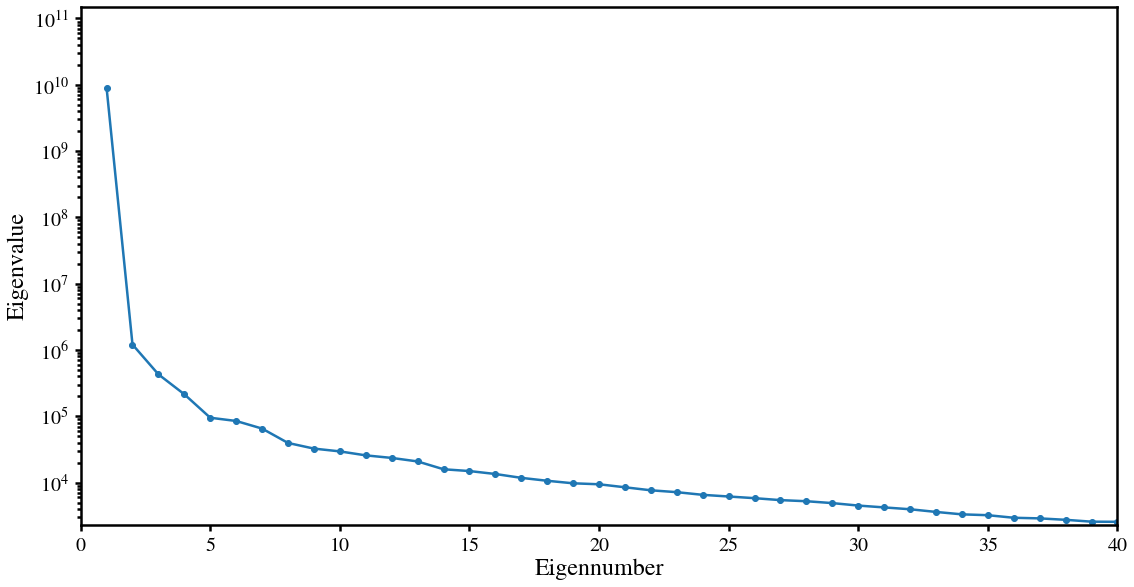

<Figure size 1296x648 with 0 Axes>

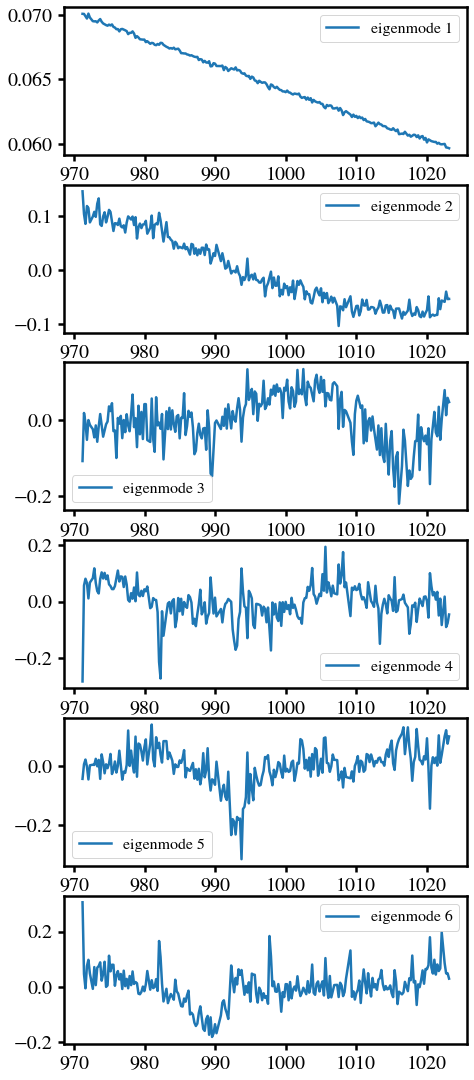

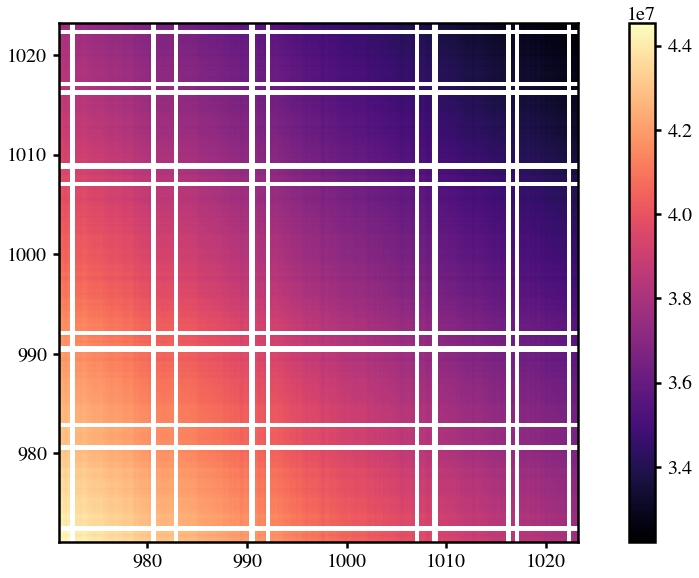

In [4]:
import foreground # PCA clean and transfer function calculations performed here
import model

if doMock==False:
    ### Analyse frequency covariance and PCA modes to guide flagging and foreground cleaning choices:
    C,eignumb,eigenval,V = foreground.PCAclean(MKmap_flag,N_fg=1,W=W_HI_flag,w=w_HI_flag,returnAnalysis=True,MeanCentre=True) # weights included in covariance calculation
    plot.EigenSpectrum(eignumb,eigenval)
    plt.figure()
    Num = 6
    chart = 100*Num + 11
    plt.figure(figsize=(7,3*Num))
    for i in range(Num):
        plt.subplot(chart + i)
        plt.plot(nu[~flags],V[:,i][~flags],label='eigenmode %s'%(i+1))
        #plt.plot(nu,V[:,i],label='eigenmode %s'%(i+1))
        plt.legend(fontsize=16)
    plt.figure()
    Cplot = np.copy(C)
    Cplot[Cplot==0] = np.nan
    plt.imshow(Cplot,extent=[nu[0],nu[-1],nu[0],nu[-1]])
    plt.colorbar()
    plt.show()

### Foreground clean:

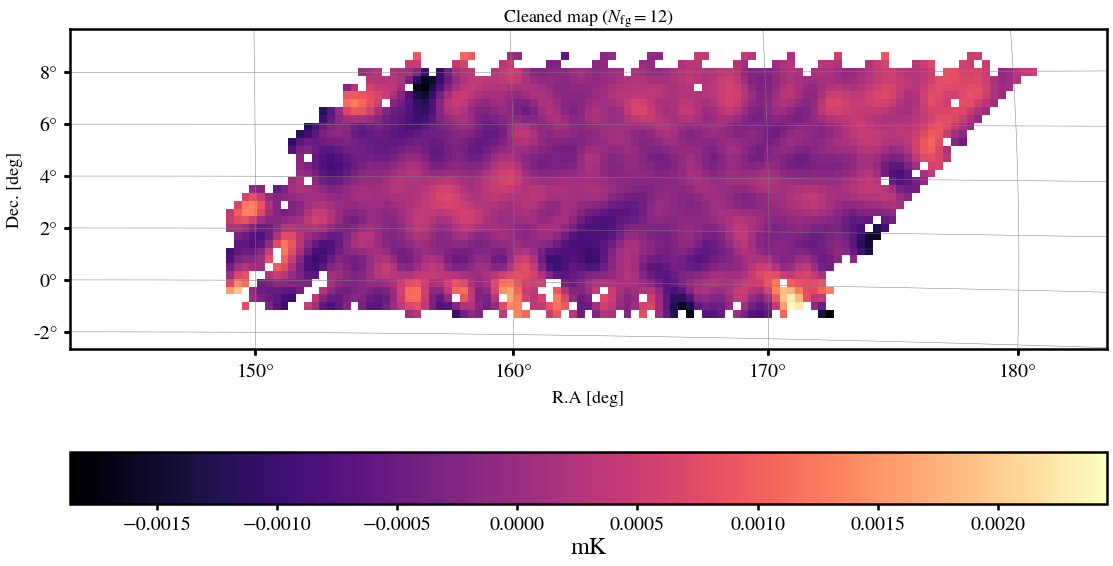

In [5]:
if survey is '2019': N_fg = 12
if survey is '2021': N_fg = 8
MKmap,w_HI,W_HI = np.copy(MKmap_flag),np.copy(w_HI_flag),np.copy(W_HI_flag) # Propagate flagged maps for rest of analysis
if doMock==False:
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
    #MKmap_clean = FGtools.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=None) # No weights
if doMock==True:
    MKmap_clean = MKmap_mock
    MKmap_clean[W_HI==0] = 0 # apply same flags, trims, cuts as data
plot.Map(MKmap_clean,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title=r'Cleaned map ($N_{\rm fg}=%s$)'%N_fg,ZeroCentre=False)
plt.show()

### Read-in overlapping galaxy survey:

Number of overlapping  wigglez  galaxies:  3995


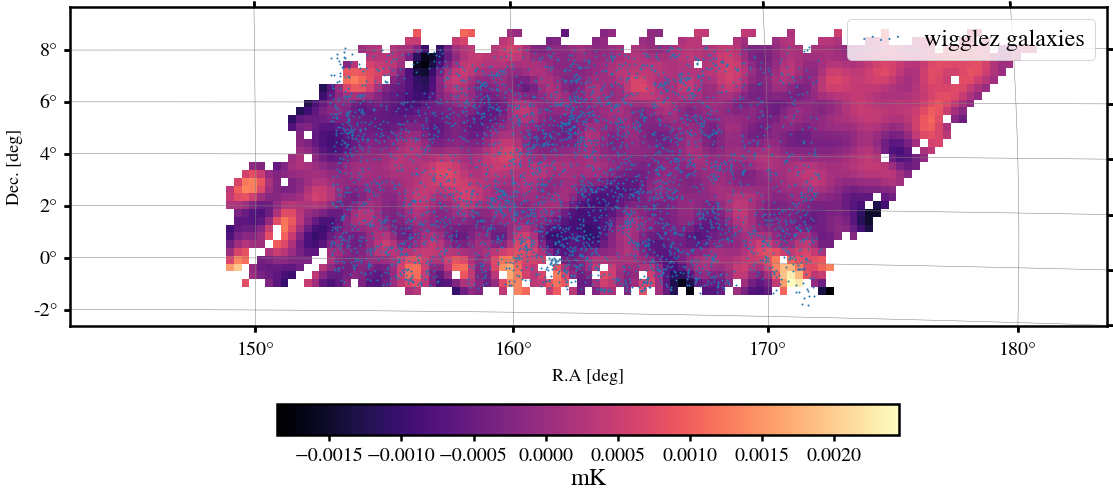

In [15]:
if survey=='2019':
    gal_cat = 'wigglez'
    #gal_cat = 'cmass'
    if gal_cat=='wigglez':
        if doMock==False:
            # Read-in WiggleZ galaxies (provided by Laura):
            galcat = np.genfromtxt('/users/scunnington/MeerKAT/LauraShare/wigglez_reg11hrS_z0pt30_0pt50/reg11data.dat', skip_header=1)
            ra_g,dec_g,z_g = galcat[:,0],galcat[:,1],galcat[:,2]
            ### Cut redshift to MeerKAT IM range:
            z_Lband = (z_g>zmin) & (z_g<zmax)
            ra_g = ra_g[z_Lband]
            dec_g = dec_g[z_Lband]
            z_g = z_g[z_Lband]
        if doMock==True: ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockWiggleZcat_%s.npy'%mockindx)
    if gal_cat=='cmass':
        if doMock==False:
            # Read-in BOSS-CMASS galaxies:
            from astropy.io import fits
            filename = '/idia/users/ycli/SDSS/dr12/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz'
            hdu = fits.open(filename)
            ra_g = hdu[1].data['RA']
            dec_g = hdu[1].data['DEC']
            z_g = hdu[1].data['Z']
        if doMock==True: ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockCMASScat_%s.npy'%mockindx)
        
        ramin_CMASS,ramax_CMASS = np.min(ra[np.mean(W_HI,2)>0]),np.max(ra[np.mean(W_HI,2)>0])
        decmin_CMASS,decmax_CMASS = np.min(dec[np.mean(W_HI,2)>0]),np.max(dec[np.mean(W_HI,2)>0])
        #ramin_CMASS,ramax_CMASS = np.min(ra),np.max(ra)
        #decmin_CMASS,decmax_CMASS = np.min(dec),np.max(dec)
        
        MKcut = (ra_g>ramin_CMASS) & (ra_g<ramax_CMASS) & (dec_g>decmin_CMASS) & (dec_g<decmax_CMASS) & (z_g>zmin) & (z_g<zmax)
        cornercut_lim1 = 146 # set low to turn off
        cornercut_lim2 = 172.5 # set high to turn off
        cornercut = (ra_g - dec_g > cornercut_lim1) & (ra_g - dec_g < cornercut_lim2)
        CMASSgalmask = MKcut & cornercut
        ra_g = ra_g[CMASSgalmask]
        dec_g = dec_g[CMASSgalmask]
        z_g = z_g[CMASSgalmask]
        
if survey=='2021':
    gal_cat = 'gama'
    if doMock==False:
        # Read-in GAMA galaxies:
        from astropy.io import fits
        Fits = '/idia/projects/hi_im/GAMA_DR4/G23TilingCatv11.fits'
        hdu = fits.open(Fits)
        hdr = hdu[1].header
        #print(hdr)
        ra_g = hdu[1].data['RA'] # Right ascension (J2000) [deg]
        dec_g = hdu[1].data['DEC'] # Declination (J2000) [deg]
        z_g = hdu[1].data['Z'] # Spectroscopic redshift, -1 for none attempted
    if doMock==True: ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockGAMAcat_%s.npy'%mockindx)
    # Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
    raminGAMA,ramaxGAMA = 339,351
    decminGAMA,decmaxGAMA = -35,-30
    GAMAcutmask = (ra_g>raminGAMA) & (ra_g<ramaxGAMA) & (dec_g>decminGAMA) & (dec_g<decmaxGAMA) & (z_g>zmin) & (z_g<zmax)
    plt.figure(figsize=(13,7))
    plt.scatter(ra_g[~GAMAcutmask],dec_g[~GAMAcutmask],s=10,label='Removed',color='tab:red')
    ra_g,dec_g,z_g = ra_g[GAMAcutmask],dec_g[GAMAcutmask],z_g[GAMAcutmask]
    plt.scatter(ra_g,dec_g,s=10,label='Kept',color='tab:blue')
    plt.xlabel('R.A [deg]',fontsize=18)
    plt.ylabel('Dec. [deg]',fontsize=18)
    plt.legend()
    plt.show()

print('Number of overlapping ', gal_cat,' galaxies: ', str(len(ra_g)))

### Plot MK map with overlaid galaxies:
plt.subplot(projection=wproj)
ax = plt.gca()
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
plt.grid(True, color='grey', ls='solid',lw=0.5)
img = np.mean(MKmap_clean,2)
img[np.sum(W_HI,2)==0] = np.nan
plt.imshow(img.T)
cbar = plt.colorbar(orientation='horizontal',shrink=0.6)
cbar.set_label('mK')
plt.scatter(ra_g,dec_g,transform=ax.get_transform('world'),s=1,label=gal_cat+' galaxies',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

# Assign galaxy bias:
if gal_cat=='wigglez':b_g = np.sqrt(0.83) # for WiggleZ at z_eff=0.41 - from https://arxiv.org/pdf/1104.2948.pdf [pg.9 rhs second quantity]
if gal_cat=='cmass':b_g = 1.85 # Mentioned in https://arxiv.org/pdf/1607.03155.pdf
if gal_cat=='gama': b_g = 1.6 # tuned by eye in GAMA auto-corr

### Gridding maps and galaxies to Cartesian field:

In [16]:
import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid
Np = 5 # number of Monte-Carlo sampling particles per map voxel used in regridding
window = 'ngp'
compensate = True
interlace = False
nxmap,nymap,nzmap = np.shape(MKmap)
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),int(nzmap/cell2vox_factor)
nzcell2vox = int(nzmap/cell2vox_factor)
if nzcell2vox % 2 != 0: nzcell2vox += 1 # Ensure z-dimension is even for FFT purposes
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),nzcell2vox
dims_rg,dims0_rg = grid.comoving_dims(ra,dec,nu,wproj,ndim_rg,W=W_HI,dobuffer=True) # dimensions of Cartesian grid for FFT
lx,ly,lz,nx_rg,ny_rg,nz_rg = dims_rg

# Regrid cleaned map and IM weights to Cartesian field:
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
MKmap_clean_rg,W_HI_rg,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_HI_rg = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)[0]

# Grid galaxies straight to Cartesian field:
xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
n_g_rg = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)[0]

# Construct galaxy selection function:
if survey=='2021': # grid uncut pixels to obtain binary mask in comoving space in absence of GAMA mocks for survey selection:
    ra_p,dec_p,nu_p = grid.SkyPixelParticles(ra,dec,nu,wproj,Np=Np)
    if doTrim==True:
        MKcutmask = (ra_p>raminMK) & (ra_p<ramaxMK) & (dec_p>decminMK) & (dec_p<decmaxMK)
        xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[MKcutmask],dec_p[MKcutmask],HItools.Freq2Red(nu_p[MKcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
        null,W_HI_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
    GAMAcutmask = (ra_p>raminGAMA) & (ra_p<ramaxGAMA) & (dec_p>decminGAMA) & (dec_p<decmaxGAMA)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[GAMAcutmask],dec_p[GAMAcutmask],HItools.Freq2Red(nu_p[GAMAcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
    null,W_g_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
    w_g_rg = np.copy(W_g_rg)
if survey=='2019': 
    if gal_cat=='wigglez': # grid WiggleZ randoms straight to Cartesian field for survey selection:
        BuildSelFunc = False
        if BuildSelFunc==True:
            nrand = 1000 # number of WiggleZ random catalogues to use in selection function (max is 1000)
            W_g_rg = np.zeros(np.shape(n_g_rg))
            for i in range(1,nrand):
                plot.ProgressBar(i,nrand)
                galcat = np.genfromtxt( '/users/scunnington/MeerKAT/LauraShare/wigglez_reg11hrS_z0pt30_0pt50/reg11rand%s.dat' %'{:04d}'.format(i), skip_header=1)
                ra_g_rand,dec_g_rand,z_g_rand = galcat[:,0],galcat[:,1],galcat[:,2]
                z_Lband = (z_g_rand>zmin) & (z_g_rand<zmax)
                ra_g_rand = ra_g_rand[z_Lband]
                dec_g_rand = dec_g_rand[z_Lband]
                z_g_rand = z_g_rand[z_Lband]
                xp,yp,zp = grid.SkyCoordtoCartesian(ra_g_rand,dec_g_rand,z_g_rand,ramean_arr=ra,decmean_arr=dec,doTile=False)
                W_g_rg += grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)[0]
            W_g_rg /= nrand
            np.save('/idia/projects/hi_im/meerpower/2019Lband/wigglez/data/wiggleZ_stackedrandoms_cell2voxfactor=%s.npy'%cell2vox_factor,W_g_rg)
        W_g_rg = np.load('/idia/projects/hi_im/meerpower/2019Lband/wigglez/data/wiggleZ_stackedrandoms_cell2voxfactor=%s.npy'%cell2vox_factor)
        
        # Calculate FKP weigts:
        '''
        W_g01_rg = np.ones(np.shape(W_g_rg)) # Binary window function for galaxies to mark dead pixels
        W_g01_rg[W_g_rg==0] = 0
        W_g_rg = W_g_rg/np.sum(W_g_rg) # normalised window function for FKP weight calculation
        P0 = 5000 # at k~0.1
        nbar = np.sum(n_g_rg)/(lx*ly*lz) # Calculate number density inside survey footprint
        w_g_rg = 1/(1 + W_g_rg*(nx*ny*nz)*nbar*P0)
        w_g_rg[W_g01_rg==0] = 0 # zero weight for dead pixels
        '''
        #w_g_rg = np.ones(np.shape(W_g_rg))
        w_g_rg = np.copy(W_g_rg)

    
    if gal_cat=='cmass':
        # Data obtained from DR12: https://data.sdss.org/sas/dr12/boss/lss/
        BuildSelFunc = False
        if BuildSelFunc==True:
            W_g_rg = np.zeros(np.shape(n_g_rg))
            for i in range(2):
                filename = '/idia/users/ycli/SDSS/dr12/random%s_DR12v5_CMASSLOWZTOT_North.fits.gz'%i
                hdu = fits.open(filename)
                ra_g_rand = hdu[1].data['RA']
                dec_g_rand = hdu[1].data['DEC']
                z_g_rand = hdu[1].data['Z']
                ramin_CMASS,ramax_CMASS = np.min(ra[np.mean(W_HI,2)>0]),np.max(ra[np.mean(W_HI,2)>0])
                decmin_CMASS,decmax_CMASS = np.min(dec[np.mean(W_HI,2)>0]),np.max(dec[np.mean(W_HI,2)>0])
                MKcut = (ra_g_rand>ramin_CMASS) & (ra_g_rand<ramax_CMASS) & (dec_g_rand>decmin_CMASS) & (dec_g_rand<decmax_CMASS) & (z_g_rand>zmin) & (z_g_rand<zmax)
                cornercut = (ra_g_rand - dec_g_rand > cornercut_lim1) & (ra_g_rand - dec_g_rand < cornercut_lim2)
                CMASSgalmask = MKcut & cornercut
                ra_g_rand = ra_g_rand[CMASSgalmask]
                dec_g_rand = dec_g_rand[CMASSgalmask]
                z_g_rand = z_g_rand[CMASSgalmask]
                xp,yp,zp = grid.SkyCoordtoCartesian(ra_g_rand,dec_g_rand,z_g_rand,ramean_arr=ra,decmean_arr=dec,doTile=False)
                W_g_rg += grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)[0]
            W_g_rg /= 2
            np.save('/idia/projects/hi_im/meerpower/2019Lband/boss/data/cmass_stackedrandoms_cell2voxfactor=%s.npy'%cell2vox_factor,W_g_rg)
        W_g_rg = np.load('/idia/projects/hi_im/meerpower/2019Lband/boss/data/cmass_stackedrandoms_cell2voxfactor=%s.npy'%cell2vox_factor)
        #w_g_rg = np.ones(np.shape(W_g_rg))
        w_g_rg = np.copy(W_g_rg)


MKmap_clean_rg_notaper,w_HI_rg_notaper,W_HI_rg_notaper = np.copy(MKmap_clean_rg),np.copy(w_HI_rg),np.copy(W_HI_rg)
n_g_rg_notaper,w_g_rg_notaper,W_g_rg_notaper = np.copy(n_g_rg),np.copy(w_g_rg),np.copy(W_g_rg)

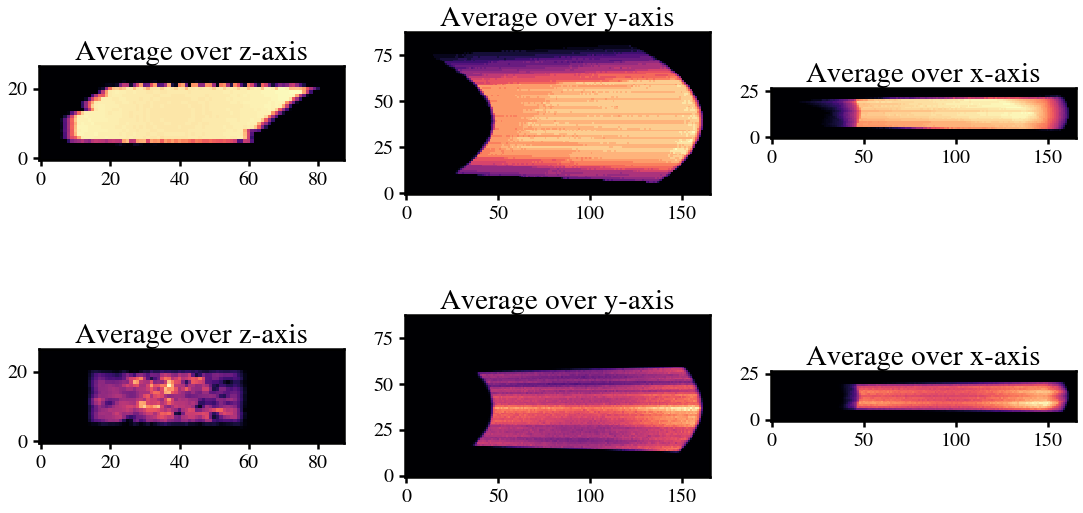

In [17]:
### Gridding sanity-check averages and looping GIFs to check footprints are well sampled (minimal holes):
fig, axs = plt.subplots(2,3)
axs[0,0].imshow(np.mean(W_HI_rg_notaper,2).T,interpolation='none')
axs[0,0].set_title('Average over z-axis')
axs[0,1].imshow(np.mean(W_HI_rg_notaper,1),interpolation='none')
axs[0,1].set_title('Average over y-axis')
axs[0,2].imshow(np.mean(W_HI_rg_notaper,0),interpolation='none')
axs[0,2].set_title('Average over x-axis')
axs[1,0].imshow(np.mean(W_g_rg_notaper,2).T,interpolation='none')
axs[1,0].set_title('Average over z-axis')
axs[1,1].imshow(np.mean(W_g_rg_notaper,1),interpolation='none')
axs[1,1].set_title('Average over y-axis')
axs[1,2].imshow(np.mean(W_g_rg_notaper,0),interpolation='none')
axs[1,2].set_title('Average over x-axis')
plt.show()

In [18]:
### Gridding sanity-check (2) averages and looping GIFs to check footprints are well sampled (minimal holes):
'''
from IPython.display import clear_output
import collections
%matplotlib inline
ix,iy,iz = 0,0,0
for i in range(np.max(ndim_rg)):
    clear_output(wait=True)
    fig, axs = plt.subplots(2,3)
    axs[0,0].set_title('Looping over z-axis')
    axs[0,0].imshow(W_HI_rg_notaper[:,:,iz].T,interpolation='none',vmin=0,vmax=1)
    axs[0,0].text(1,1,'iz=%s'%iz,color='yellow')
    axs[0,1].set_title('Looping over y-axis')
    axs[0,1].imshow(W_HI_rg_notaper[:,iy,:],interpolation='none',vmin=0,vmax=1)
    axs[0,1].text(1,1,'iy=%s'%iy,color='yellow')
    axs[0,2].set_title('Looping over x-axis')
    axs[0,2].imshow(W_HI_rg_notaper[ix,:,:],interpolation='none',vmin=0,vmax=1)
    axs[0,2].text(1,1,'ix=%s'%ix,color='yellow')
    axs[1,0].set_title('Looping over z-axis')
    axs[1,0].imshow(W_g_rg_notaper[:,:,iz].T,interpolation='none',vmin=0,vmax=np.max(W_g_rg))
    axs[1,0].text(1,1,'iz=%s'%iz,color='yellow')
    axs[1,1].set_title('Looping over y-axis')
    axs[1,1].imshow(W_g_rg_notaper[:,iy,:],interpolation='none',vmin=0,vmax=np.max(W_g_rg))
    axs[1,1].text(1,1,'iy=%s'%iy,color='yellow')
    axs[1,2].set_title('Looping over x-axis')
    axs[1,2].imshow(W_g_rg_notaper[ix,:,:],interpolation='none',vmin=0,vmax=np.max(W_g_rg))
    axs[1,2].text(1,1,'ix=%s'%ix,color='yellow')
    plt.show();
    if i<(nx_rg-1): ix += 1
    if i<(ny_rg-1): iy += 1
    if i<(nz_rg-1): iz += 1
'''

"\nfrom IPython.display import clear_output\nimport collections\n%matplotlib inline\nix,iy,iz = 0,0,0\nfor i in range(np.max(ndim_rg)):\n    clear_output(wait=True)\n    fig, axs = plt.subplots(2,3)\n    axs[0,0].set_title('Looping over z-axis')\n    axs[0,0].imshow(W_HI_rg_notaper[:,:,iz].T,interpolation='none',vmin=0,vmax=1)\n    axs[0,0].text(1,1,'iz=%s'%iz,color='yellow')\n    axs[0,1].set_title('Looping over y-axis')\n    axs[0,1].imshow(W_HI_rg_notaper[:,iy,:],interpolation='none',vmin=0,vmax=1)\n    axs[0,1].text(1,1,'iy=%s'%iy,color='yellow')\n    axs[0,2].set_title('Looping over x-axis')\n    axs[0,2].imshow(W_HI_rg_notaper[ix,:,:],interpolation='none',vmin=0,vmax=1)\n    axs[0,2].text(1,1,'ix=%s'%ix,color='yellow')\n    axs[1,0].set_title('Looping over z-axis')\n    axs[1,0].imshow(W_g_rg_notaper[:,:,iz].T,interpolation='none',vmin=0,vmax=np.max(W_g_rg))\n    axs[1,0].text(1,1,'iz=%s'%iz,color='yellow')\n    axs[1,1].set_title('Looping over y-axis')\n    axs[1,1].imshow(W_g_r

### Footprint tapering/apodisation:

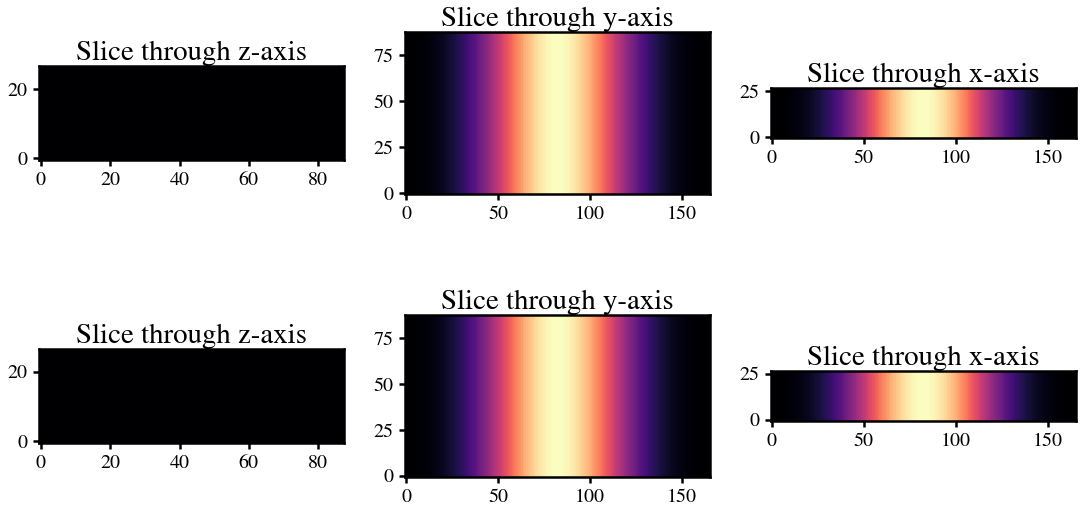

In [19]:
### Chose no taper:
#taper_HI,taper_g = 1,1

### Chose to use Blackman window function along z direction as taper:
blackman = np.reshape( np.tile(np.blackman(nz_rg), (nx_rg,ny_rg)) , (nx_rg,ny_rg,nz_rg) ) # Blackman function along every LoS
taper_HI = blackman
taper_g = blackman
#taper_g = 1

### Chose to implement a Gaussian footprint edge smoothing window functions:
'''
if survey=='2019': 
    taper_HI = grid.GaussianFootprintTaper(W_HI_rg)
    taper_g = 1
if survey=='2021': taper_HI,taper_g = grid.GaussianFootprintTaper(W_HI_rg,W_g_rg)
'''

# Multiply tapering windows by all fields that undergo Fourier transforms:
MKmap_clean_rg,w_HI_rg,W_HI_rg = taper_HI*MKmap_clean_rg_notaper,taper_HI*w_HI_rg_notaper,taper_HI*W_HI_rg_notaper
n_g_rg,W_g_rg,w_g_rg = taper_g*n_g_rg_notaper,taper_g*W_g_rg_notaper,taper_g*w_g_rg_notaper

fig, axs = plt.subplots(2,3)
if taper_HI is not 1:
    axs[0,0].imshow(taper_HI[:,:,int(nz_rg/2)].T,interpolation='none')
    axs[0,0].set_title('Slice through z-axis')
    axs[0,1].imshow(taper_HI[:,int(ny_rg/2),:],interpolation='none')
    axs[0,1].set_title('Slice through y-axis')
    axs[0,2].imshow(taper_HI[int(nx_rg/2),:,:],interpolation='none')
    axs[0,2].set_title('Slice through x-axis')
if taper_g is not 1:
    axs[1,0].imshow(taper_g[:,:,int(nz_rg/2)].T,interpolation='none')
    axs[1,0].set_title('Slice through z-axis')
    axs[1,1].imshow(taper_g[:,int(ny_rg/2),:],interpolation='none')
    axs[1,1].set_title('Slice through y-axis')
    axs[1,2].imshow(taper_g[int(nx_rg/2),:,:],interpolation='none')
    axs[1,2].set_title('Slice through x-axis')
plt.show()

### Power spectrum measurement and modelling (without signal loss correction):

0.03481546954807381


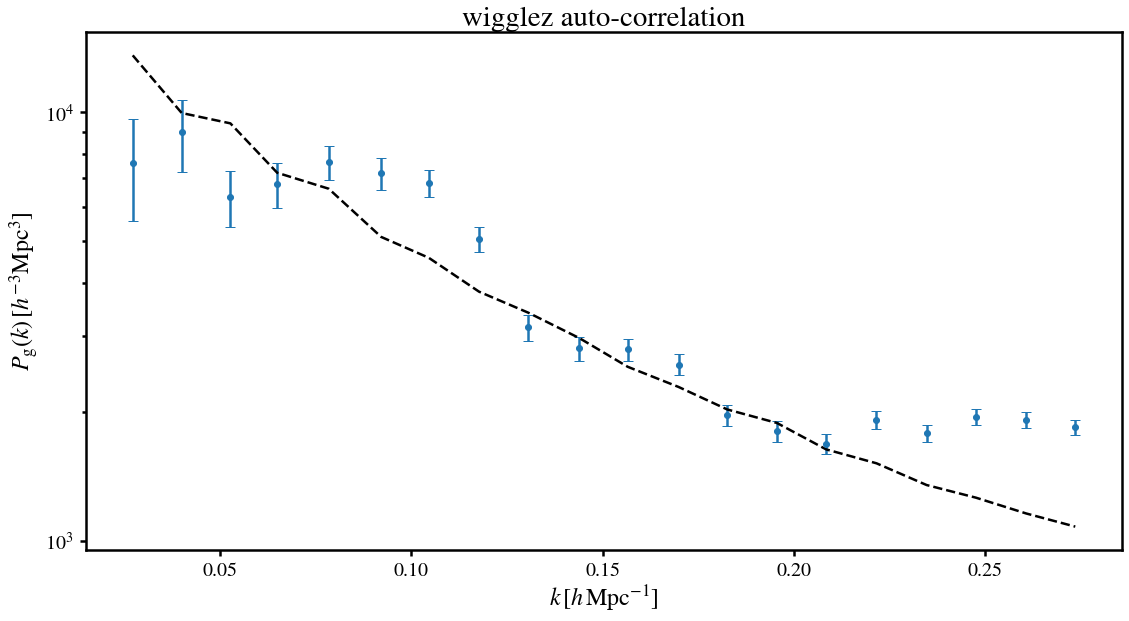

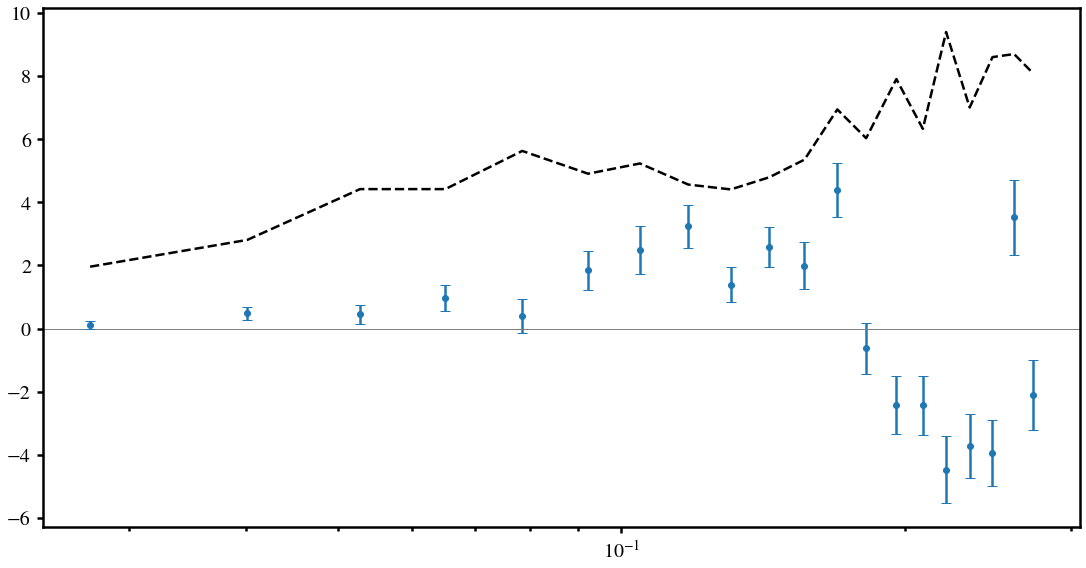

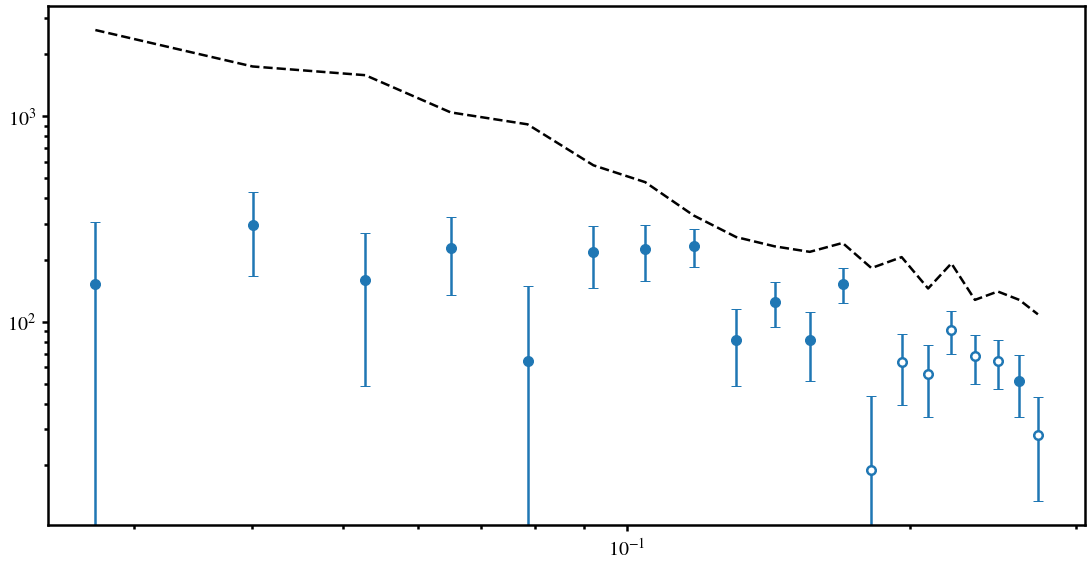

In [20]:
import power
import model
if survey=='2019':
    nkbin = 20
    kmin,kmax = 0.02,0.28
if survey=='2021':
    nkbin = 15
    kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
kcuts = None
if gal_cat=='wigglez': kcuts = [None,None,0.14,None] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)
if gal_cat=='cmass': kcuts = [0.025,None,0.14,None] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)

import model
sig_v = 0
dpix = 0.3
d_c = cosmo.d_com(HItools.Freq2Red(np.min(nu)))
s_pix = d_c * np.radians(dpix)
s_para = np.mean( cosmo.d_com(HItools.Freq2Red(nu[:-1])) - cosmo.d_com(HItools.Freq2Red(nu[1:])) )

### Galaxy Auto-power (can use to constrain bias and use for analytical errors):
Pk_g,k,nmodes = power.Pk(n_g_rg,n_g_rg,dims_rg,kbins,corrtype='Galauto',w1=w_g_rg,w2=w_g_rg,W1=W_g_rg,W2=W_g_rg)
W_g_rg /= np.max(W_g_rg)
Vfrac = np.sum(W_g_rg)/(nx_rg*ny_rg*nz_rg)
print(Vfrac)
nbar = np.sum(n_g_rg)/(lx*ly*lz*Vfrac) # Calculate number density inside survey footprint
P_SN = np.ones(len(k))*1/nbar # approximate shot-noise for errors (already subtracted in Pk estimator)
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_g,b_g,f,sig_v,Tbar1=1,Tbar2=1,r=1,R_beam1=0,R_beam2=0,w1=w_g_rg,w2=w_g_rg,W1=W_g_rg,W2=W_g_rg,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
sig_g = 1/np.sqrt(nmodes)*(Pk_g+P_SN)
plt.errorbar(k,Pk_g,sig_g,ls='none',marker='o')
plt.plot(k,pkmod,color='black',ls='--')
plt.yscale('log')
plt.title(gal_cat+' auto-correlation')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm g}(k)\,[h^{-3}{\rm Mpc}^{3}]$')
plt.axhline(0,lw=0.8,color='black')
plt.show()

'''
# Reassign N_fg for foreground cleaning if required:
N_fg = 8
MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
MKmap_clean_rg,W_HI_rg,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
MKmap_clean_rg = taper_HI*MKmap_clean_rg
'''

# Calculate auto and cross-power specs:
Pk_HI,k,nmodes = power.Pk(MKmap_clean_rg,MKmap_clean_rg,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W_HI_rg,W2=W_HI_rg)
Pk_gHI,k,nmodes = power.Pk(MKmap_clean_rg,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts)
P_SN = np.ones(len(k))*1/nbar # approximate shot-noise for errors (already subtracted in Pk estimator)
sig_err = 1/np.sqrt(2*nmodes) * np.sqrt( Pk_gHI**2 + Pk_HI*( Pk_g + P_SN ) ) # Error estimate

if gamma is not None: 
    theta_FWHM_max,R_beam_max = telescope.getbeampars(D_dish,np.min(nu))
    R_beam_gam = R_beam_max * np.sqrt(gamma)
else: R_beam_gam = np.copy(R_beam)
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=r,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]

plt.axhline(0,lw=1,color='gray')
plt.errorbar(k,k**2*Pk_gHI,k**2*sig_err,ls='none',marker='o')
plt.plot(k,k**2*pkmod,ls='--',color='black')
plt.xscale('log')
plt.figure()

plt.errorbar(k,np.abs(Pk_gHI),sig_err,ls='none',marker='o',markersize=10)
plt.scatter(k[Pk_gHI<0],np.abs(Pk_gHI[Pk_gHI<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)
plt.plot(k,pkmod,ls='--',color='black')
plt.loglog()
plt.show()

### Analyse 2D power:

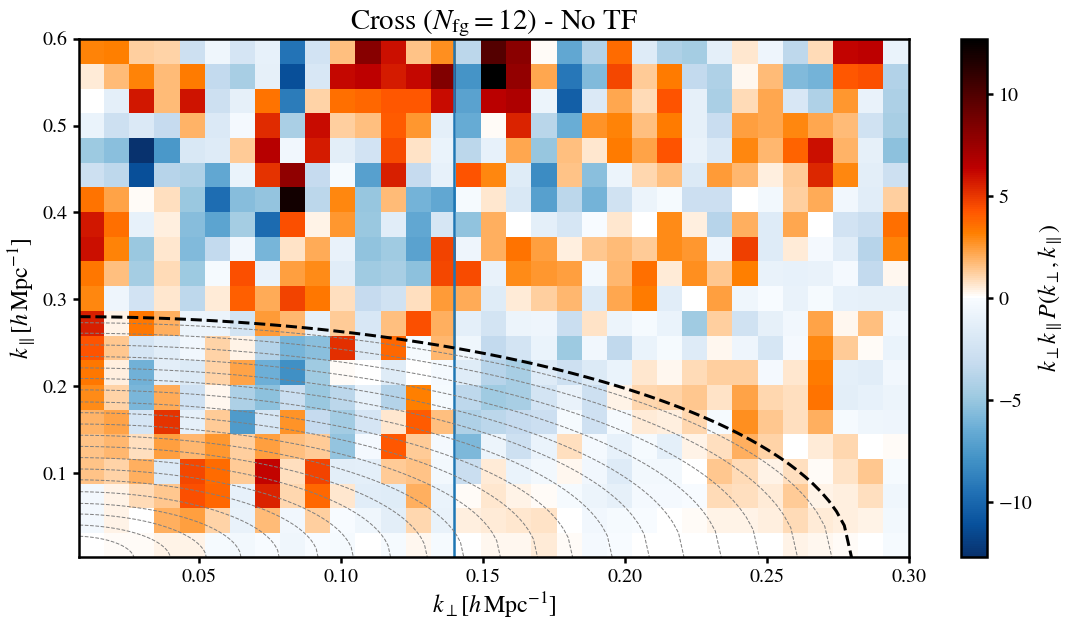

In [21]:
### Chose 2D k-bins:
kperpbins = np.linspace(0.008,0.3,34)
kparabins = np.linspace(0.003,0.6,22)
kperpcen = (kperpbins[1:] + kperpbins[:-1])/2
kparacen = (kparabins[1:] + kparabins[:-1])/2
kperpgrid = np.tile(kperpcen,(len(kparacen),1))
kparagrid = np.tile(kparacen,(len(kperpcen),1))
kparagrid = np.swapaxes(kparagrid,0,1)
kgrid = kperpcen * kparacen[:,np.newaxis]

### Create split colorbar for 2D Pk negative values:
import matplotlib.colors as mcolors
colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

Pk2D,k2d,nmodes = power.Pk2D(MKmap_clean_rg,n_g_rg,dims_rg,kperpbins,kparabins,'Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg)

vmaxX = np.max(kgrid*Pk2D)
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D,cmap=mycmap,vmin=-vmaxX,vmax=vmaxX)
if kcuts[0] is not None: plt.axvline(kcuts[0])
if kcuts[2] is not None: plt.axvline(kcuts[2])
if kcuts[1] is not None: plt.axhline(kcuts[1])
if kcuts[3] is not None: plt.axhline(kcuts[3])
### 1D k_max contour:
kperp = np.linspace(np.min(kperpbins),kmax,100)
kpara = np.linspace(np.min(kparabins),kmax,100)
kcont = np.sqrt(kmax**2 - kpara**2)
plt.plot(kperp,kcont,color='black',ls='--',lw=3)
for i in range(nkbin):
    kperp = np.linspace(np.min(kperpbins),k[i],100)
    kpara = np.linspace(np.min(kparabins),k[i],100)
    kcont = np.sqrt(k[i]**2 - kpara**2)
    plt.plot(kperp,kcont,color='gray',ls='--',lw=1)
    
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlim(left=kperpbins[0])
plt.ylim(bottom=kparabins[0])
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Cross ($N_{\rm fg}=%s$) - No TF'%N_fg)
plt.show()

### Compare $N_{\rm fg}$ results:

10
0 5
1 6
2 7
3 8
4 9
5 10
6 11
7 12
8 15
9 20


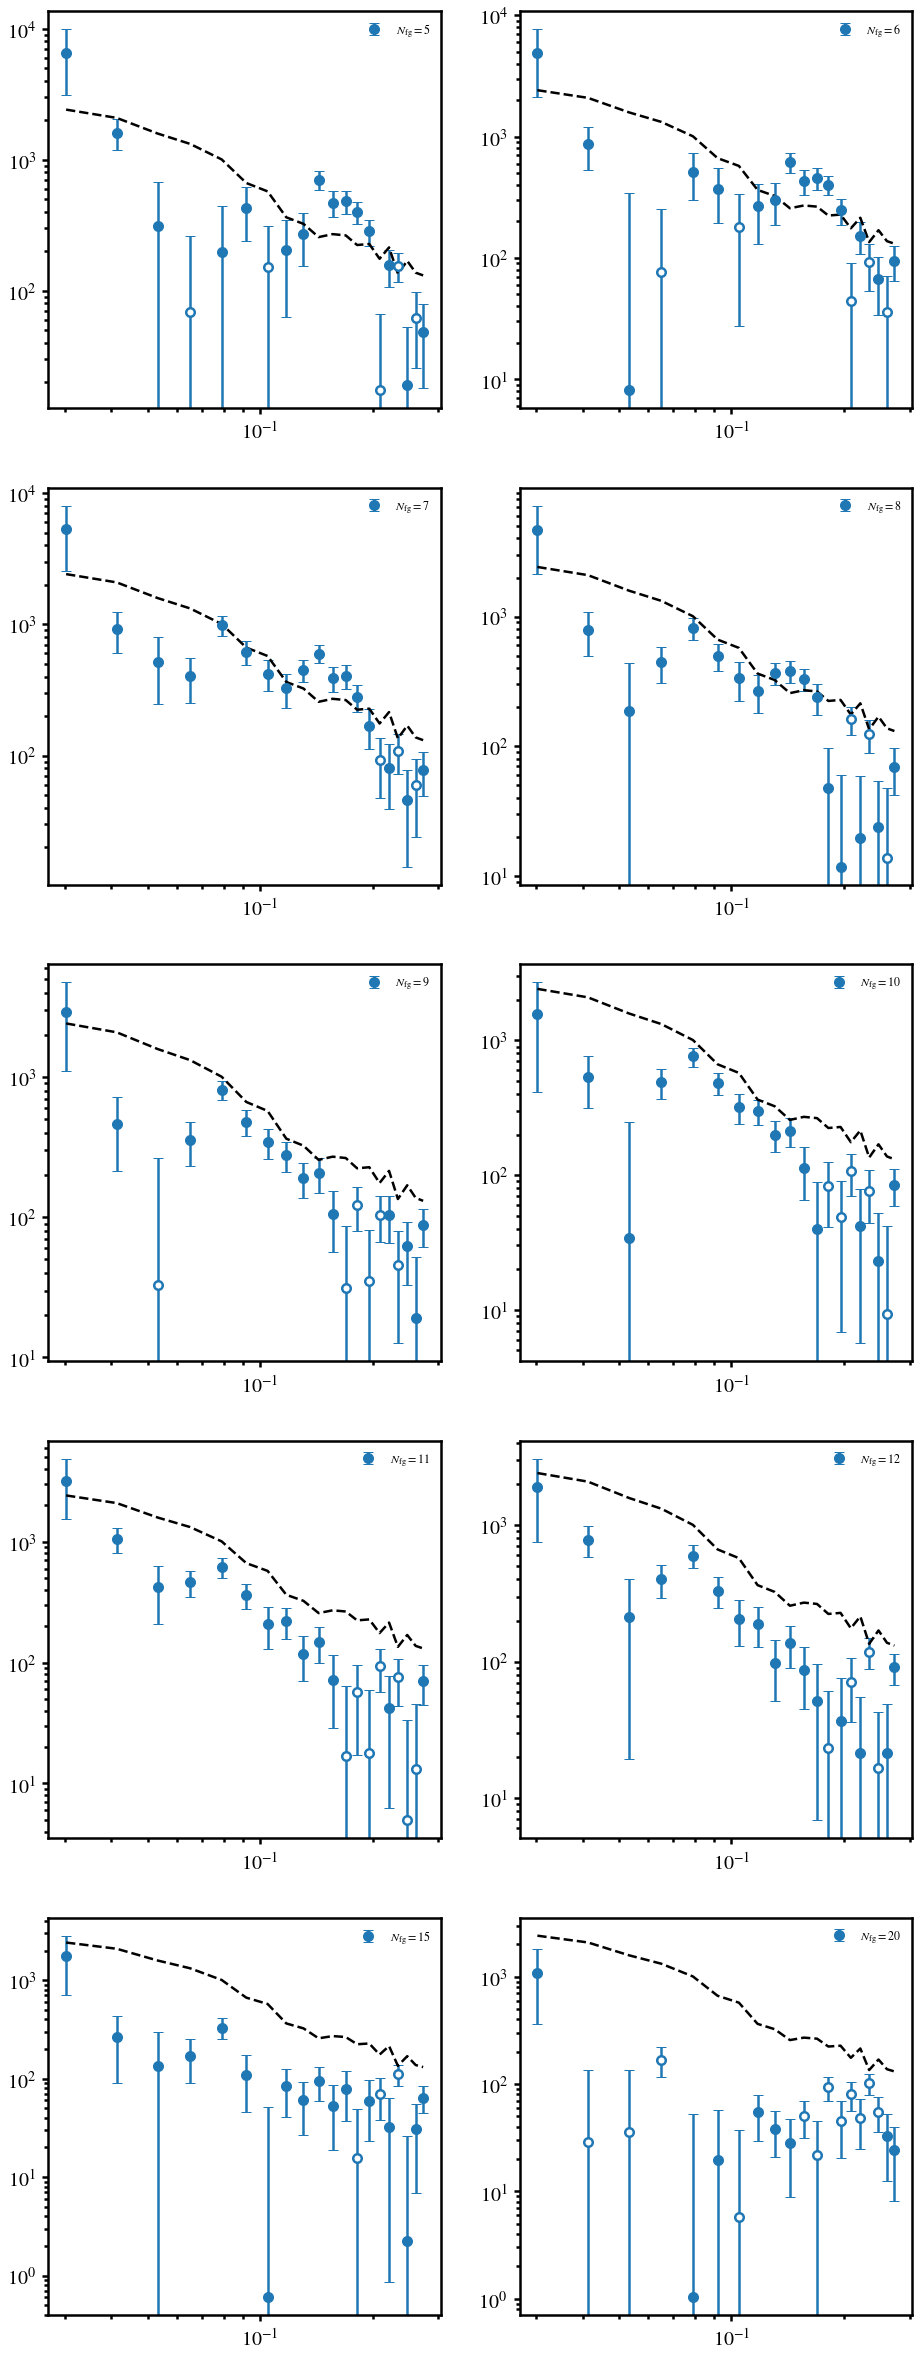

In [13]:
N_fgs = [5,6,7,8,9,10,11,12,15,20]
print(len(N_fgs))

fig, axs = plt.subplots(int(len(N_fgs)/2),2,figsize=(15,40))
for i in range(len(N_fgs)):
    print(i,N_fgs[i])
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fgs[i],W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    MKmap_clean_rg,W_HI_rg,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
    MKmap_clean_rg = taper_HI*MKmap_clean_rg

    # Calculate auto and cross-power specs:
    Pk_HI,k,nmodes = power.Pk(MKmap_clean_rg,MKmap_clean_rg,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W_HI_rg,W2=W_HI_rg)
    Pk_gHI,k,nmodes = power.Pk(MKmap_clean_rg,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts)
    sig_err = 1/np.sqrt(2*nmodes) * np.sqrt( Pk_gHI**2 + Pk_HI*( Pk_g + P_SN ) ) # Error estimate

    if i%2==0: yi = 0
    else: yi = 1
    axs[int(i/2),yi].errorbar(k,np.abs(Pk_gHI),sig_err,ls='none',marker='o',markersize=10,label=r'$N_{\rm fg}=%s$'%N_fgs[i])
    axs[int(i/2),yi].scatter(k[Pk_gHI<0],np.abs(Pk_gHI[Pk_gHI<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)
    axs[int(i/2),yi].plot(k,pkmod,ls='--',color='black')
    axs[int(i/2),yi].loglog()
    axs[int(i/2),yi].legend(fontsize=12,frameon=False)
plt.show()

### Calculate/Load Transfer function:
##### - use to correct signal loss, analyse covariance and assign errors:

Errors for the reconstructed power spectrum $P_{\rm rec}(k) = P_{\rm clean}(k)/T(k)$ are propagated from the transfer function distributions $T(k)+\Delta T_i(k)$ obtained from each $i$th mock. We assume the errors add in quadrature, hence $\Delta P_{{\rm rec},i}/P_{\rm rec} = \sqrt{(\Delta P_{{\rm clean},i}/P_{\rm clean})^2 + (\Delta T_i/T)^2}$. We assume all quantifiable error lies in the TF distribution, hence $\Delta P_{{\rm clean},i} = 0$ and therefore $\Delta P_{{\rm rec},i} = P_{\rm rec} \frac{{\Delta T},i}{T}$. The uncertainties for the error bars can then be obtained from the 68th percentile regions of the reconstructed power distribution $P_{{\rm rec},i}(k) = P_{\rm rec}(k) + \Delta P_{{\rm rec},i}(k)$ 

In [16]:
LoadTF = True
Nmock = 500
if gamma is None: gamma_label = 'None'
else: gamma_label = str(gamma)
TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T_Nfg=%s_gamma=%s'%(N_fg,gamma_label)
mockfilepath_HI = '/idia/projects/hi_im/meerpower/2019Lband/mocks/dT_HI_p0.3d_wBeam'
mockfilepath_g = '/idia/projects/hi_im/meerpower/2019Lband/mocks/mockWiggleZcat'
T_wsub_i, T_nosub_i,k  = foreground.TransferFunction(MKmap_unsmoothed,Nmock,N_fg,'Cross',kbins,k,TFfile,ra,dec,nu,wproj,dims0_rg,
                                            Np,window,compensate,interlace,mockfilepath_HI,mockfilepath_g,
                                            gamma=gamma,D_dish=D_dish,w_HI=w_HI,W_HI=W_HI,doWeightFGclean=True,PCAMeanCentre=True,
                                            w_HI_rg=w_HI_rg,W_HI_rg=W_HI_rg,w_g_rg=w_g_rg,W_g_rg=W_g_rg,
                                            taper_HI=blackman,taper_g=blackman,LoadTF=LoadTF)
T_wsub_i = np.array(T_wsub_i,dtype=np.float64)
T_nosub_i = np.array(T_nosub_i,dtype=np.float64)
k = np.array(k,dtype=np.float64)
Nmock = np.shape(T_wsub_i)[0]

T_i = np.copy(T_nosub_i)
T = np.mean(T_i,0)
deltaT_i = T_i - T
Pk_rec = pk_gHI/T
#Pk_rec = pk_gHI/np.mean(T_wsub_i)

plt.axhline(0,lw=0.8,color='black')
plt.axhline(1,lw=0.8,color='black')
plt.errorbar(k,np.mean(T_wsub_i,0),np.std(T_wsub_i,0),label='with [] sub',zorder=0)
plt.errorbar(k+0.002,np.mean(T_nosub_i,0),np.std(T_nosub_i,0),label='no [] sub',ls='--',zorder=0)
for i in range(Nmock):
    if i==0: plt.plot(k,T_nosub_i[i],lw=0.2,color='gray',label='no [] sub realisations')
    else: plt.plot(k,T_nosub_i[i],lw=0.2,color='gray')
plt.legend(fontsize=12)
plt.title(r'$N_{\rm fg}=%s$ (%s mocks)'%(N_fg,Nmock))
plt.xlabel(r'$k$')
plt.ylabel(r'$T(k)$')
plt.ylim(-0.5,1.5)
plt.show()

# Propagate error on TF into error on power:
deltaPk_i =  Pk_rec * (deltaT_i/T) 
Pk_rec_i = Pk_rec + deltaPk_i # corrected power uncertainty distribution

# Calculate 68th percentile regions for non-symmetric/non-Gaussian errors:
### 68.27%/2 = 34.135%. So 50-34.135 -> 50+34.135 covers 68th percentile region:
lower_error = np.abs(np.percentile(deltaPk_i,15.865,axis=0))
upper_error = np.abs(np.percentile(deltaPk_i,84.135,axis=0))
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

# k-bin covariance from TF:
kgrid = k * k[:,np.newaxis]
C = kgrid**3*np.cov(Pk_rec_i,rowvar=False)
plt.imshow(C,origin='lower',extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.colorbar()
plt.title(r'$(k_ik_j)^3\times$ Covariance ($N_{\rm fg}=%s$)'%N_fg,fontsize=20)
plt.show()

# Noramlised k-bin correlation matrix:
R = np.corrcoef(Pk_rec_i,rowvar=False)
plt.imshow(R,origin='lower',cmap='RdBu_r',vmin=-1,vmax=1,extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.colorbar()
plt.title(r'Normalised covariance "correlation matrix" ($N_{\rm fg}=%s$)'%N_fg,fontsize=20)
plt.show()

# Plot results, correcting for signal loss and with simulation-based errors:
# Chose factorisation of P(k) in plotting:
norm = np.ones(nkbin)
#norm = k**2

plt.errorbar(k,norm*np.abs(Pk_rec),norm*asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$'%N_fg,markersize=10)
plt.scatter(k[Pk_rec<0],norm[Pk_rec<0]*np.abs(Pk_rec[Pk_rec<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)
plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
if norm[0]==1.0: plt.yscale('log')
plt.axhline(0,lw=0.8,color='black')
plt.legend(fontsize=12,loc='upper right',frameon=False)
plt.title('MeerKAT x WiggleZ')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
#plt.savefig('plots/Pk_GAMAxMK.png',bbox_inches='tight')
plt.show()

for i in range(Nmock):
    plt.plot(k,k**2*Pk_rec_i[i],lw=0.2,color='gray',zorder=-1)
plt.errorbar(k,k**2*Pk_rec,k**2*asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$ (percentile)'%N_fg,markersize=10)
#plt.errorbar(k*1.01,k**2*Pk_rec,k**2*np.std(Pk_X/T_nosub,0),ls='none',marker='o',label=r'$N_{\rm fg}=%s$ (rms)'%N_fgs[indx_choice],markersize=10,alpha=0.5)
plt.plot(k,k**2*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.axhline(0,lw=0.8,color='black')
plt.legend(fontsize=12,loc='upper right',frameon=False)
plt.title('MeerKAT x WiggleZ')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.ylim(-3*np.abs(np.min(k**2*Pk_rec)),3*np.max(k**2*Pk_rec))
plt.show()

### Histogram of TF mock distributions to show error profile for each k-bin:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(16,12))
k_ind = 0
for row in ax:
    for col in row:
        dum, = col.plot(0,label=r'$k=%s$'%np.round(k[k_ind],3),color='white') # dummy line to show k-value in legend
        legend1 = col.legend([dum], [r'$k=%s$'%np.round(k[k_ind],3)], loc='upper left',fontsize=16,handlelength=0,handletextpad=0,frameon=False,borderaxespad=0.1)
        col.add_artist(legend1)
        mod = col.axvline(pkmod[k_ind],color='black',ls='--',lw=2,zorder=8)
        median = col.axvline(np.median(Pk_rec_i[:,k_ind]),color='tab:blue',ls='-',lw=1,zorder=9)
        span = col.axvspan(np.percentile(Pk_rec_i[:,k_ind],50-34.1,axis=0), np.percentile(Pk_rec_i[:,k_ind],50+34.1,axis=0), alpha=0.4, color='tab:blue',zorder=-10,label='68th percentile')
        if k_ind==0:
            legend2 = col.legend([mod,median,span], ['Model','Median','68th percentile'], loc='upper right',fontsize=12,frameon=False,handlelength=1.5,handletextpad=0.4,borderaxespad=0.1)
            col.add_artist(legend2)
        hist,bins = np.histogram(Pk_rec_i[:,k_ind],bins=30)
        bins = (bins[1:] + bins[:-1])/2
        col.plot(bins,hist,ds='steps')
        col.set_xlim(bins[0],bins[-1])
        col.set_ylim(0)
        if k_ind>=12: col.set_xlabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
        k_ind += 1
plt.subplots_adjust(hspace=0.4)
plt.suptitle(r'Power distribution from %s TF mocks for each $k$ ($N_{\rm fg}=%s$)'%(Nmock,N_fgs[indx_choice]))
plt.show()

### Analyse Chi^2 and detection significance (requires an assumption of Gaussian distribution in uncertainties so take the mean of the 68th percentile boundaries):
#kbin_cut = k>0
kbin_cut = (k>0.065) & (k<0.20)
#kbin_cut = k>0.14
det_sig = model.DetectionSigma(Pk_rec[kbin_cut],pkmod[kbin_cut],np.mean(asymmetric_error,0)[kbin_cut])
print('Reduced Chi^2: ' + str(model.ChiSquare(Pk_rec[kbin_cut],pkmod[kbin_cut],np.mean(asymmetric_error,0)[kbin_cut],dof=len(k[kbin_cut]))))

FileNotFoundError: [Errno 2] No such file or directory: '/idia/projects/hi_im/meerpower/2019Lband/cmass/TFdata/T_Nfg=12_gamma=1.4.npy'